In [3]:
import numpy as np
import pandas as pd
from statistics import mean
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

In [137]:
df = pd.read_json('Q1_rankings.json', lines=True)

In [139]:
df['gender'] = df.apply(lambda row: row.treatment.get('gender'), axis=1)
df['ethnicity'] = df.apply(lambda row: row.treatment.get('ethnicity'), axis=1)

In [140]:
def price_row(row):
    if len(row['ranking'])>0:
        if 'price' in row['ranking'][0]:
            return row['ranking']
    else:
        return '0'

In [141]:
df['position'] = df.apply(lambda row: price_row(row), axis=1)

In [142]:
df = df[['scraper','gender','ethnicity','position']]
df = df.dropna()

In [143]:
def price(row):
    ls = []
    for i in row['position']:
        if i is not None and type(i) is dict:
            pc = i.get('price')
            if 'K' in pc:
                pc = pc.replace('K','000')
            if '+' in pc:
                pc = pc.replace('+','')   
            iprice = int(pc.replace(',', '')[1:])
            ls.append(iprice)
    return ls


In [144]:
df['price'] = df.apply(lambda row: price(row) , axis=1)

In [145]:
def locate(row):
    for i in row['position']:
        if i is not None and type(i) is dict:
            lo = i.get('locality')
            if lo is not None:
                if 'Champaign' in lo or 'CHAMPAIGN' in lo:
                    return 'Champaign'
                elif 'Chicago' in lo or 'CHICAGO' in lo:
                    return 'Chicago'
                else:
                    return None

In [146]:
df['locality'] = df.apply(lambda row:locate(row),axis=1)

In [147]:
df = df.dropna()
df = df.reset_index(drop=True)

In [148]:
df['price_mean'] = df.apply(lambda row: round(mean(row['price'])) , axis=1)

In [149]:
average_price_groups = df.groupby(['scraper','locality','gender', 'ethnicity']).agg({'price_mean': ['mean']}).astype(int)

In [150]:
average_price_groups

price_mean
                                                mean
scraper locality  gender ethnicity                  
Realtor Champaign female african american     186316
                         asian                252004
                         caucasian            231455
                         hispanic             184872
                  male   african american     216065
                         asian                219872
                         caucasian            406047
                         hispanic             337737
        Chicago   female african american     298285
                         asian                415222
                         caucasian            316717
                         hispanic             442223
                  male   african american     385510
                         asian                220265
                         caucasian            453362
                         hispanic             226040
Trulia  Champaign female african american     227334
                         asian                154322
                         caucasian            189099
                         hispanic             202994
                  male   african american     241794
                         asian                206394
                         caucasian            212565
                         hispanic             209941
        Chicago   female african american     278855
                         asian                167330
                         caucasian            207702
                         hispanic             270710
                  male   african american     220710
                         asian                270710
                         caucasian            219837
                         hispanic             270710

In [158]:
model_R = ols('price_mean ~ C(gender) + C(ethnicity) + C(gender):C(ethnicity)', data=df).fit()

In [159]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),4.963485e+11,1.0,2.653768,0.105927
C(ethnicity),5.881739e+11,3.0,1.048240,0.373923
C(gender):C(ethnicity),7.953801e+11,3.0,1.417522,0.241038
Residual,2.244425e+13,120.0,NaN,NaN


In [151]:
Realtor = df[df.scraper == 'Realtor']

In [152]:
model_R = ols('price_mean ~ C(gender) + C(ethnicity) + C(gender):C(ethnicity)', data=Realtor).fit()

In [153]:
sm.stats.anova_lm(model_R, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),8.479322e+09,1.0,0.296231,0.588416
C(ethnicity),6.017691e+10,3.0,0.700773,0.555552
C(gender):C(ethnicity),1.414801e+11,3.0,1.647567,0.188770
Residual,1.602947e+12,56.0,NaN,NaN


In [154]:
Trulia = df[df.scraper == 'Trulia']

In [155]:
model_T = ols('price_mean ~ C(gender) + C(ethnicity) + C(gender):C(ethnicity)', data=Trulia).fit()

In [156]:
sm.stats.anova_lm(model_T, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),5.953299e+09,1.0,1.029292,0.314688
C(ethnicity),2.233558e+10,3.0,1.287233,0.287715
C(gender):C(ethnicity),2.143603e+10,3.0,1.235390,0.305489
Residual,3.238970e+11,56.0,NaN,NaN


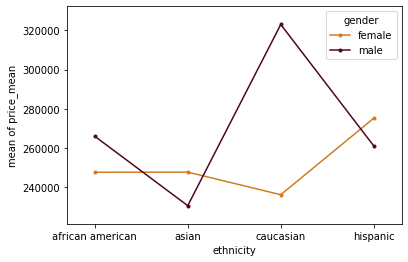

In [160]:
fig = interaction_plot(x=df['ethnicity'], trace=df['gender'], response=df['price_mean'], 
    colors=['#d17a22', '#4c061d'])
plt.show()

In [164]:
df[['rank1','rank2','rank3','rank4','rank5','rank6','rank7','rank8','rank9','rank10']] = pd.DataFrame(df.price.tolist(), index= df.index)

In [173]:
gender_ranks = df.groupby(['gender']).agg({'rank1': ['mean'],'rank2': ['mean'],'rank3': ['mean'],'rank4': ['mean'],
                                           'rank5': ['mean'],'rank6': ['mean'],'rank7': ['mean'],'rank8': ['mean'],
                                           'rank9': ['mean'],'rank10': ['mean']}).astype(int)
gender_ranks

,rank1,rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9,rank10
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
gender,,,,,,,,,,
female,318977,355289,237716,258034,276249,200149,237090,238449,193032,201037
male,315757,410554,236965,232790,228399,288504,303998,237104,204999,255522


Text(0, 0.5, 'Average Price')

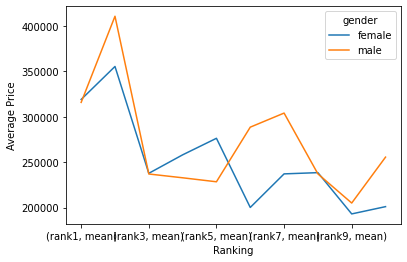

In [189]:
gender_ranks.T.plot()
plt.xlabel('Ranking')
plt.ylabel('Average Price')

In [174]:
ethnicity_ranks = df.groupby(['ethnicity']).agg({'rank1': ['mean'],'rank2': ['mean'],'rank3': ['mean'],'rank4': ['mean'],
                                           'rank5': ['mean'],'rank6': ['mean'],'rank7': ['mean'],'rank8': ['mean'],
                                           'rank9': ['mean'],'rank10': ['mean']}).astype(int)
ethnicity_ranks

,rank1,rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9,rank10
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
ethnicity,,,,,,,,,,
african american,202515,339178,264096,303712,306562,264315,219434,248508,211846,208418
asian,441371,308315,231290,271257,159699,169465,192952,227265,199162,201952
caucasian,361709,328133,223555,205952,313024,348065,337521,261846,197249,218921
hispanic,264075,552605,230468,202304,233002,189940,328087,213571,187059,280421


Text(0, 0.5, 'Average Price')

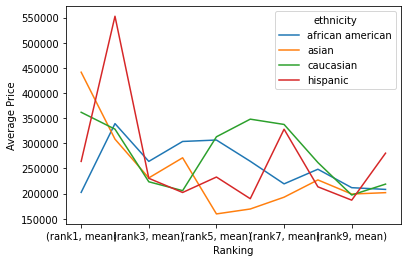

In [190]:
ethnicity_ranks.T.plot()
plt.xlabel('Ranking')
plt.ylabel('Average Price')